# **N腕バンディット問題**

事前に当たりの確率が設定されたスロットマシンがN台並んでいる。
ただし、**ユーザ（エージェント）はその確率を事前に知らない。**

エージェントは、1回の試行で1つのスロットマシン i を選んで引く。

スロットマシンを1回引くと、事前に定義された確率p_iに基づき、「当たり(=1)」または「外れ(=0)」という形で**報酬**が与えられる(ベルヌーイ試行)。

エージェントは、試行回数あたりの平均報酬を最大化したい。砕けた言い方をすると、スロットで出来るだけ多くの当たりを引きたい（しかし、前述のとおり、エージェントは各スロットが当たりを出す確率を知らない）。

In [1]:
import random
import numpy as np

random.seed(0) #seedを指定して乱数を取得

#0から4までの5つのスロットのうち、ランダムで選択した1つを番号で返す
def random_select():
  
  
  slot_num = random.randint(0,4)
  return slot_num

print(random_select())
  

3


# **環境**
N腕バンディット問題では、（強化学習における）**環境**とは次のことを意味する。

**エージェントがスロットを引き、スロットが事前に設定された確率に基づき、報酬（「当たり」または「外れ」）を出すという、プロセス**である。

In [2]:
#乱数のseedを固定する
np.random.seed(0)

#指定したスロットを1回引き結果を返す(環境)
def environments(band_number):
  
  #各スロットが当たりを出す確率を配列に格納
  coins_p = np.array([0.3, 0.4, 0.5, 0.6, 0.7])
  
  #各スロットを1回引いた結果を計算(結果は二項分布に従う)
  results = np.random.binomial(1, coins_p)
  #print(results)
  
  #引数で指定したスロットの結果を返す
  result = results[band_number]
  return result

print(environments(random_select()))

1


# **報酬**

N腕バンディット問題では、（強化学習における）**報酬**とは次のことを意味する。

**スロットから得られる結果（「当たり」または「外れ」）そのもの**である。

In [0]:
times = 10000  #総試行回数
record = np.zeros(times) #各試行における報酬

#各スロットの報酬に関するデータテーブル、属性は次の通り
#[スロット番号, 選択回数, 報酬合計, 報酬合計/選択回数]
results = [[0,0,0,0], 
           [1,0,0,0],
           [2,0,0,0],
           [3,0,0,0],
           [4,0,0,0]]


#ある試行回数目におけるスロットの結果を返す（報酬）
def reward(record, results, slot_num, time):
  
  #指定したスロットの結果を取得する
  result = environments(slot_num)
  
  #指定した試行回数目における報酬を更新
  record[time] = result
  
  #指定したスロットの報酬に関するデータテーブルを更新
  results[slot_num][1] += 1      #選択回数を1増やす
  results[slot_num][2] += result #報酬合計を更新
  results[slot_num][3] = results[slot_num][2]/results[slot_num][1] #報酬合計/選択回数を更新
  
  return results, record

# 方策その1:greedy手法
はじめのうちは、各スロットをn回ずつ選ぶ（スロットの確率を探索）。

探索によって得られた情報から、最も期待値の大きい（「当たり」の確率が大きい）スロット選択する。

In [0]:
#greedy手法でスロットを選択
def greedy(results, n):
    # 試行回数がnより少ないマシンがある場合、slot_numをそのマシンの腕番号にする 
    slot_num = None
    for i, d in enumerate(results): #スロット番号とデータテーブルを列挙
        if d[1]<n:
            slot_num = i
            break
        
    # どのマシンの試行回数もnより大きい場合、slot_numを報酬の期待値の高いものにする
    if slot_num == None:
        slot_num = np.array([row[3] for row in results]).argmax() #データテーブル（行列）の三列目の最大要素を取得（最大の報酬平均）
        
    return slot_num

#方策その2:ε-greedy手法
確率εで、ランダムにスロットを選択する。

確率1-εで、最も期待値の大きいスロットを選択する。

In [0]:
#ε-greedy手法でスロットを選択
def epsilon_greedy(results, epsilon):
  
  # 確率εで全てのマシンの中からランダムに選択する
    if np.random.binomial(1, epsilon):
        slot_num = np.random.randint(0,4)
        
    # 確率1-εでn=0のgreedy手法を実行
    else:
        slot_num = None
        for i, d in enumerate(results):
          
            if d[1] == 0:#一度も選んでいないスロットがあれば、そのスロットを選ぶ
                slot_num = i
                break

        if slot_num == None:#どのスロットも1度以上選んでいるならば、報酬の期待値が最大のスロットを選ぶ
            slot_num = np.array([row[3] for row in results]).argmax()
            
    return slot_num

# 方策その３:楽観的初期値法

In [0]:
# 楽観的初期値法
def optimistic(results, K, rsup):
  
    # スロットごとの報酬の期待値を計算して、配列に格納
    optimistic_mean = np.array([(row[2]+K*rsup)/(row[1]+K) for row in results])
    
    # 最も報酬の期待値が大きいスロットを選択
    slot_num = optimistic_mean.argmax()
    return slot_num

# 平均報酬の推移

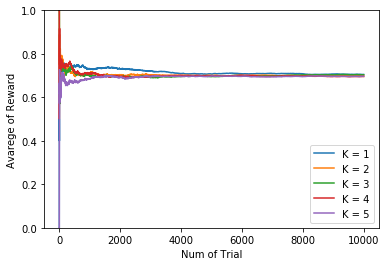

In [8]:
#各試行回数における報酬を取得し、データテーブルを更新
import matplotlib.pyplot as plt
%matplotlib inline

n = 100 #greedy手法における探索回数
epsilons = [0.01, 0.1, 0.2] #ε-greedy手法における確率（比較のため3つ定義）

#greedy手法
#for time in range(0, times):
#  slot_num = random_select()   #ランダムでスロットを選択するという方策
#  slot_num = greedy(results, n) #greedy手法でスロットを選択するという方策
#  results, record = reward(record, results, slot_num, time)
#print(results)

#ε-greedy手法
#for epsilon in epsilons:
#  for time in range(0, times):
#    slot_num = epsilon_greedy(results, epsilon)
#    results, record = reward(record, results, slot_num, time)
#  plt.plot(np.cumsum(record) / np.arange(1, record.size + 1), label ="epsilon = %s" %str(epsilon))

#楽観的初期値法
Ks = range(1, 6)
for K in Ks:
  for time in range(0, times):
    slot_num = optimistic(results, K, 1)
    results, record = reward(record, results, slot_num, time)
  plt.plot(np.cumsum(record) / np.arange(1, record.size + 1), label ="K = %s" %str(K))


# recordを用いて平均報酬の推移をプロット
plt.legend()
plt.xlabel("Num of Trial")
plt.ylabel("Avarege of Reward")
plt.ylim(0,1) #y軸の範囲
plt.show()